# Import Packages

In [5]:
import csv
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

import matplotlib.pyplot as plt


from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

# import cleaned data

In [12]:
data_clean = pd.read_csv('data_clean.csv')
data_clean.sample(frac=1)
data_clean = data_clean[:30000]
Characters_per_rank = (data_clean.Characters.value_counts()).index 

# Deep Learning Model with Keras

In [3]:
# define a function to perform DL Modeling on a dataset with /without resampling

def DL_Model(DataFrame, Labels, Sampling = None):

    train_posts, test_posts, train_tags,test_tags = train_test_split(DataFrame , Labels,
                                                  test_size = .2,
                                                  random_state=12)
   
    max_words = 10000
    tokenize = text.Tokenizer(num_words=max_words, char_level=False)
    tokenize.fit_on_texts(train_posts) # only fit on train
    
    x_train = tokenize.texts_to_matrix(train_posts)
    x_test = tokenize.texts_to_matrix(test_posts)
    
    y_train = train_tags
    y_test = test_tags
    
    
    if Sampling:
        x_train, y_train = Sampling.fit_sample(x_train,  y_train)
       
    num_classes = np.max(y_train) + 1
    y_train = utils.to_categorical(y_train, num_classes)
    y_test = utils.to_categorical(y_test, num_classes)


    batch_size = 32
    epochs = 2

    # Build the model

    model = Sequential()
    model.add(Dense(512, input_shape=(max_words,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',

              optimizer='adam',

              metrics=['accuracy'])

              
    history = model.fit(x_train, y_train,

                    batch_size=batch_size,

                    epochs=epochs,

                    verbose=1,

                    validation_split=0.1)
    
    
    y_prob = model.predict_proba(x_test)
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro")
    score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
    print('Test accuracy:', score[1])
    print("roc_auc:",macro_roc_auc_ovo)
    return score[1],macro_roc_auc_ovo

In [4]:
#truncate dataset based on number of characters we want to verify and perform DL modeling on original dataset
number_characters_to_consider = [2,3,5,8,10,12,15]
Accuracy = []
ROC_AUC = []
for threshold in number_characters_to_consider:
    data_thres = data_clean[data_clean.Characters.isin(Characters_per_rank[:threshold])]

    # Label Character
    label = LabelEncoder()
    target_thres = label.fit_transform(data_thres['Characters'].astype(str))
    
    acc_this_loop, roc_this_loop = DL_Model(data_thres['Lines'], target_thres)
    
    Accuracy.append(acc_this_loop)
    ROC_AUC.append(roc_this_loop)

Train on 6670 samples, validate on 742 samples
Epoch 1/2
6670/6670 [==============================] - 25s 4ms/step - loss: 0.6566 - accuracy: 0.5981 - val_loss: 0.6296 - val_accuracy: 0.6213
Epoch 2/2
1854/1854 [==============================] - 1s 337us/step
Test accuracy: 0.6386191844940186
roc_auc: 0.703880246558062
Train on 9929 samples, validate on 1104 samples
Epoch 1/2
9929/9929 [==============================] - 38s 4ms/step - loss: 1.0561 - accuracy: 0.4246 - val_loss: 1.0185 - val_accuracy: 0.4583
Epoch 2/2
2759/2759 [==============================] - 1s 325us/step
Test accuracy: 0.4715476632118225
roc_auc: 0.6715724661326056
Train on 15935 samples, validate on 1771 samples
Epoch 1/2
15935/15935 [==============================] - 63s 4ms/step - loss: 1.5489 - accuracy: 0.2933 - val_loss: 1.5043 - val_accuracy: 0.3320
Epoch 2/2
4427/4427 [==============================] - 6s 1ms/step
Test accuracy: 0.33002033829689026
roc_auc: 0.6533353951169547
Train on 18926 samples, validat

# Deep Learning Model on Oversampled Data

In [ ]:
## truncate dataset based on number of characters we want to verify and perform DL modeling on oversampled dataset
number_characters_to_consider  = [2,3,5,8,10,12,15]
Accuracy_OS = []
ROC_AUC_OS = []
for threshold in number_characters_to_consider:
    data_thres = data_clean[data_clean.Characters.isin(Characters_per_rank[:threshold])]
    print(threshold)
    # Label Character
    label = LabelEncoder()
    target_thres = label.fit_transform(data_thres['Characters'].astype(str))
    
    ros_ov = RandomOverSampler(random_state=0)
    acc_this_loop, roc_this_loop = DL_Model(data_thres['Lines'], target_thres,ros_ov)
    
    Accuracy_OS.append(acc_this_loop)
    ROC_AUC_OS.append(roc_this_loop)

In [2]:
# store results and save as a csv file for plotting
data_for_plotting = {
    'Neural_Network_ACC':Accuracy,
   'Neural_Network_ROC': ROC_AUC,
   'ROS_Neural_Network_ACC':Accuracy_OS,
    'ROS_Neural_Network_ROC':ROC_AUC_OS}
d = pd.DataFrame(data_for_plotting)
d.to_csv('Sampling_NN_Results.csv')

NameError: name 'Accuracy' is not defined

# Comparison: Linear Classifiers vs Deep Learning Model

In [11]:
number_characters_to_consider = [2,3,5,8,10,12,15]

b = pd.read_csv('Naive_Bayes.csv')

(0.5, 0.75)

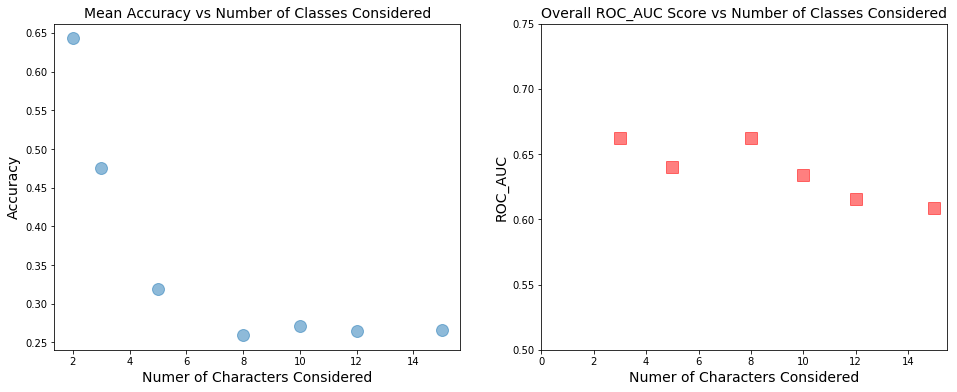

In [12]:
# Compare modeling results before and after applying sampling techniques 
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)


plt.plot(number_characters_to_consider,b['Naive_Bayes Acc'],marker = 'o' , markersize =12, linestyle = 'none', label = 'Naive Bayes with imbalanced data',alpha =0.5)
plt.xlabel('Numer of Characters Considered',FontSize=14)
plt.ylabel('Accuracy',FontSize=14)

plt.title('Mean Accuracy vs Number of Classes Considered',FontSize=14)

plt.subplot(1, 2, 2)
plt.plot(number_characters_to_consider[1:], b['Naive_Bayes ROC'][1:],marker = 's', color = 'r',markersize =12, linestyle = 'none', label = 'imbalanced data',alpha =0.5)
plt.title('Overall ROC_AUC Score vs Number of Classes Considered',FontSize=14)
plt.xlabel('Numer of Characters Considered',FontSize=14)
plt.ylabel('ROC_AUC',FontSize=14)
plt.xlim([0,15.5])
plt.ylim([0.5,0.75])

In [13]:
d = pd.read_csv('Sampling_NN_Results.csv')

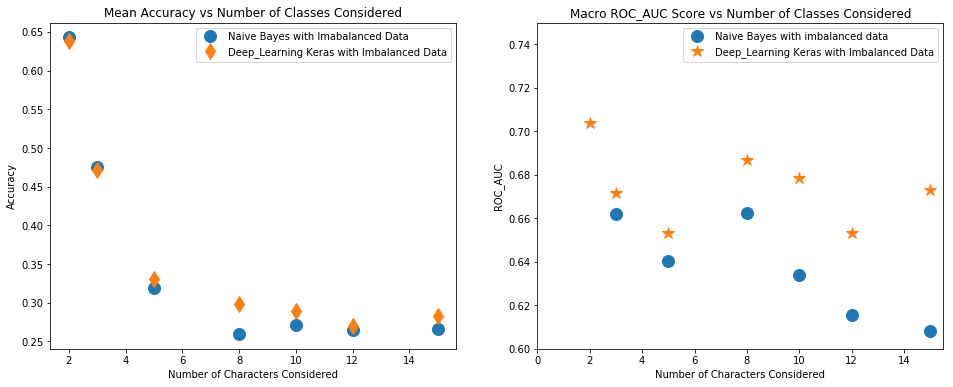

In [9]:
# Compare modeling results before and after applying sampling techniques 
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)


plt.plot(number_characters_to_consider,b['Naive_Bayes Acc'],marker = 'o', markersize =12, linestyle = 'none', label = 'Naive Bayes with Imabalanced Data ')

plt.plot(number_characters_to_consider,d['Neural_Network_ACC'],marker = 'd', markersize =12, linestyle = 'none', label = 'Deep_Learning Keras with Imbalanced Data')
plt.xlabel('Number of Characters Considered')
plt.ylabel('Accuracy')
plt.legend(loc ='upper right')
plt.title('Mean Accuracy vs Number of Classes Considered')

plt.subplot(1, 2, 2)
plt.plot(number_characters_to_consider[1:], b['Naive_Bayes ROC'][1:],marker = 'o', markersize =12, linestyle = 'none',  label = 'Naive Bayes with imbalanced data')
plt.plot(number_characters_to_consider, d['Neural_Network_ROC'], marker = '*', markersize =12, linestyle = 'none', label = 'Deep_Learning Keras with Imbalanced Data')
#plt.plot(number_characters_to_consider, ROC_AUC_OS,marker = 'd' , markersize =12, linestyle = 'none', label = 'Neural Network Random OverSampling')

plt.title('Macro ROC_AUC Score vs Number of Classes Considered')
plt.xlabel('Number of Characters Considered')
plt.ylabel('ROC_AUC')
plt.xlim([0,15.5])
plt.ylim([0.6,0.75])
plt.legend()
plt.legend(loc ='upper right')

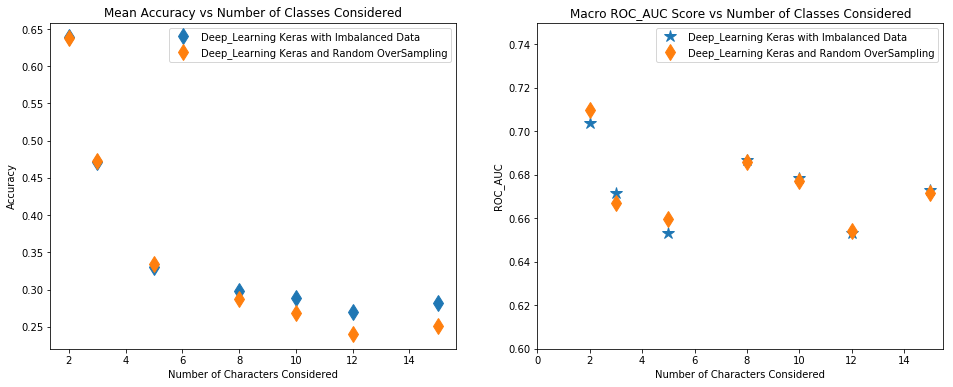

In [10]:
# Compare modeling results before and after applying sampling techniques 
plt.figure(figsize = (16, 6))
plt.subplot(1, 2, 1)

plt.plot(number_characters_to_consider,d['Neural_Network_ACC'],marker = 'd', markersize =12, linestyle = 'none', label = 'Deep_Learning Keras with Imbalanced Data')
plt.plot(number_characters_to_consider, d['ROS_Neural_Network_ACC'],marker = 'd' , markersize =12, linestyle = 'none', label = 'Deep_Learning Keras and Random OverSampling')

plt.xlabel('Number of Characters Considered')
plt.ylabel('Accuracy')
plt.legend(loc ='upper right')
plt.title('Mean Accuracy vs Number of Classes Considered')

plt.subplot(1, 2, 2)

plt.plot(number_characters_to_consider, d['Neural_Network_ROC'], marker = '*', markersize =12, linestyle = 'none', label = 'Deep_Learning Keras with Imbalanced Data')
plt.plot(number_characters_to_consider, d['ROS_Neural_Network_AROC'],marker = 'd' , markersize =12, linestyle = 'none', label = 'Deep_Learning Keras and Random OverSampling')

plt.title('Macro ROC_AUC Score vs Number of Classes Considered')

plt.xlabel('Number of Characters Considered')
plt.ylabel('ROC_AUC')
plt.xlim([0,15.5])
plt.ylim([0.6,0.75])
plt.legend()
plt.legend(loc ='upper right')